In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.stats import pearsonr, linregress
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import sys
import pickle
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)

Stripy is not available on this machine.


<module 'community' from '/science/users/4302001/arctic-connectivity/tools/community.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

## March 1993-2018 (90 Days)

In [4]:
marchDict = {}
for year in range(1993, 2019):
    marchDict[year] = {}

for year in range(1993, 2019):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    marchDict[year]['avg_codelength'] = np.mean(results['codelengths'])
    marchDict[year]['std_codelength'] = np.std(results['codelengths'])
    marchDict[year]['avg_global_coherence'] = results['avg_global_coherence']
    marchDict[year]['std_global_coherence'] = np.std(results['globalCoherence'])
    marchDict[year]['avg_global_mixing'] = results['avg_global_mixing']
    marchDict[year]['std_global_mixing'] = np.std(results['globalMixing'])
marchDF = pd.DataFrame.from_dict(marchDict, orient='index')

In [5]:
cmems_dims = xr.open_dataset("/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/statics/GLO-MFC_001_030_coordinates.nc")
cell_areas = cmems_dims.e1t[1680:, :]*cmems_dims.e2t[1680:, :]

In [6]:
seaIceArrMarch = []
for year in range(1993, 2019):
    ds = xr.open_dataset(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_{year}03.nc")
    seaIceArrMarch.append(np.nansum(cell_areas*ds.siconc[0, 1680:, :])/1000000)
marchDF["sea_ice"] = seaIceArrMarch

In [7]:
marchDF.corr()

,avg_codelength,std_codelength,avg_global_coherence,std_global_coherence,avg_global_mixing,std_global_mixing,sea_ice
avg_codelength,1.000000,0.413858,0.245865,0.408384,0.150886,0.484501,-0.502112
std_codelength,0.413858,1.000000,0.201021,0.259532,0.340011,0.268711,0.025862
avg_global_coherence,0.245865,0.201021,1.000000,0.158455,-0.117391,0.077936,-0.111884
std_global_coherence,0.408384,0.259532,0.158455,1.000000,-0.082597,0.760038,-0.497019
avg_global_mixing,0.150886,0.340011,-0.117391,-0.082597,1.000000,-0.362623,-0.197912
std_global_mixing,0.484501,0.268711,0.077936,0.760038,-0.362623,1.000000,-0.250266
sea_ice,-0.502112,0.025862,-0.111884,-0.497019,-0.197912,-0.250266,1.000000


In [8]:
marchDF.corr(method=lambda x, y: pearsonr(x, y)[1])

,avg_codelength,std_codelength,avg_global_coherence,std_global_coherence,avg_global_mixing,std_global_mixing,sea_ice
avg_codelength,1.000000,0.035573,0.226008,0.038336,0.461875,0.012131,0.008954
std_codelength,0.035573,1.000000,0.324771,0.200423,0.089221,0.184394,0.900201
avg_global_coherence,0.226008,0.324771,1.000000,0.439445,0.567919,0.705110,0.586334
std_global_coherence,0.038336,0.200423,0.439445,1.000000,0.688319,0.000007,0.009791
avg_global_mixing,0.461875,0.089221,0.567919,0.688319,1.000000,0.068664,0.332467
std_global_mixing,0.012131,0.184394,0.705110,0.000007,0.068664,1.000000,0.217543
sea_ice,0.008954,0.900201,0.586334,0.009791,0.332467,0.217543,1.000000


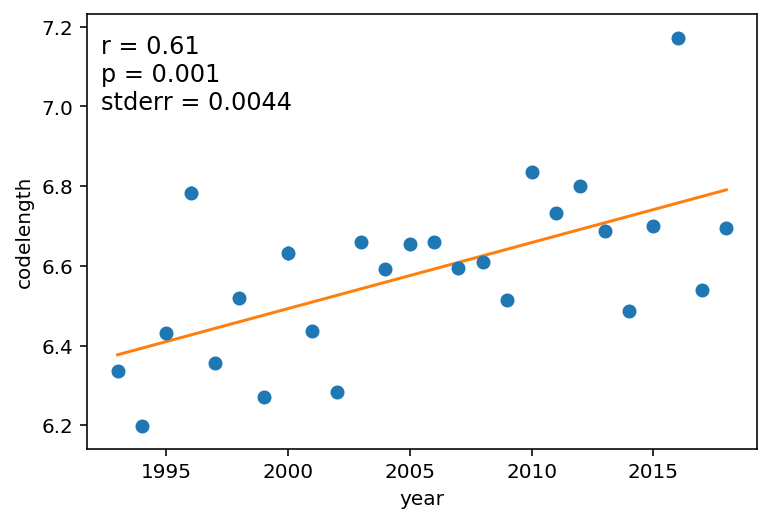

In [11]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), marchDF['avg_codelength'])
plt.errorbar(np.arange(1993, 2019), marchDF['avg_codelength'].values, yerr=marchDF['std_codelength'], fmt='o')
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s)
plt.ylabel("codelength")
plt.xlabel("year")
# plt.margins(x=0, y=0.1)
ax=plt.gca()
ax.text(0.02, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
#plt.tight_layout(True)
plt.savefig("figures/evol_codelength_march.pdf", dpi=300, bbox_inches='tight')

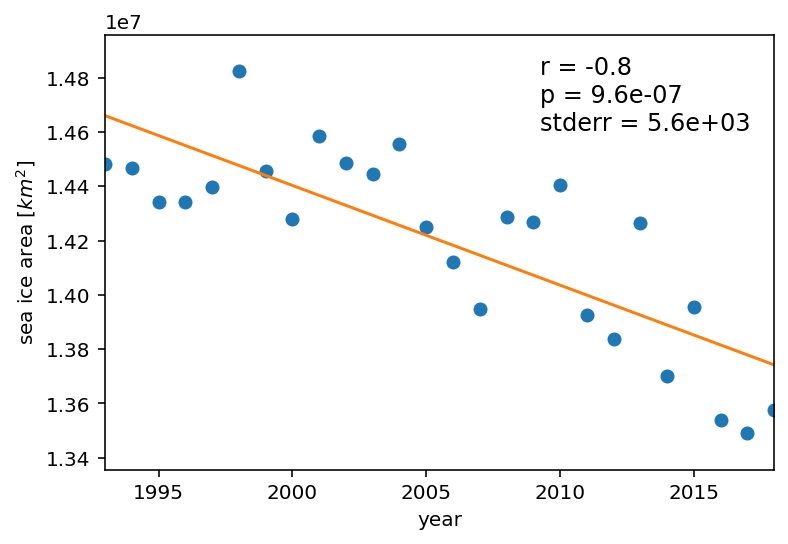

In [13]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), marchDF['sea_ice'])
plt.scatter(np.arange(1993, 2019), marchDF['sea_ice'])
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s, c='C1')
plt.ylabel(r"sea ice area [$km^2$]")
plt.xlabel("year")
plt.margins(x=0, y=0.1)
ax=plt.gca()
ax.text(0.65, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
plt.savefig("figures/evol_sea_ice_march.pdf", dpi=300, bbox_inches='tight')

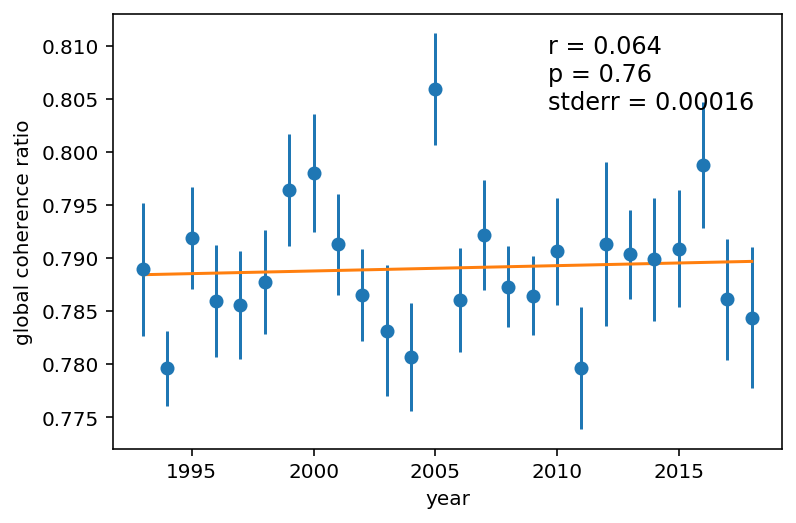

In [15]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), marchDF['avg_global_coherence'])
plt.errorbar(np.arange(1993, 2019), marchDF['avg_global_coherence'].values, yerr=marchDF['std_global_coherence'], fmt='o')
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s)
plt.ylabel("global coherence ratio")
plt.xlabel("year")
# plt.margins(x=0, y=0.1)
ax = plt.gca()
ax.text(0.65, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
plt.savefig("figures/evol_coherence_march.pdf", dpi=300, bbox_inches='tight')

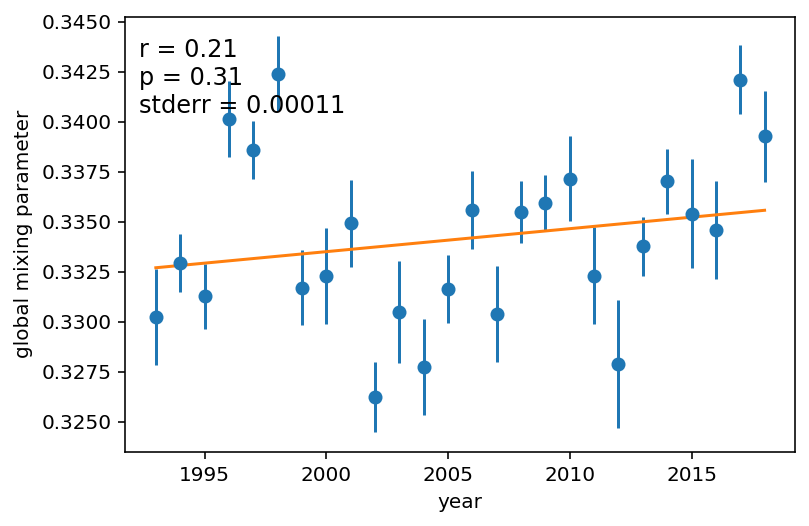

In [17]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), marchDF['avg_global_mixing'])
plt.errorbar(np.arange(1993, 2019), marchDF['avg_global_mixing'].values, yerr=marchDF['std_global_mixing'], fmt='o')
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s)
plt.ylabel("global mixing parameter")
plt.xlabel("year")
# plt.margins(x=0, y=0.1)
ax = plt.gca()
ax.text(0.02, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
plt.savefig("figures/evol_mixing_march.pdf", dpi=300, bbox_inches='tight')

## September 1993-2018

In [19]:
septDict = {}
for year in range(1993, 2019):
    septDict[year] = {}

for year in range(1993, 2019):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    septDict[year]['avg_codelength'] = np.mean(results['codelengths'])
    septDict[year]['std_codelength'] = np.std(results['codelengths'])
    septDict[year]['global_coherence'] = results['avg_global_coherence']
    septDict[year]['std_global_coherence'] = np.std(results['globalCoherence'])
    septDict[year]['global_mixing'] = results['avg_global_mixing']
    septDict[year]['std_global_mixing'] = np.std(results['globalMixing'])

septDF = pd.DataFrame.from_dict(septDict, orient='index')

In [20]:
seaIceArrSept = []
veloArrSept = []
for year in range(1993, 2019):
    dsSept = xr.open_dataset(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_{year}09.nc")
    dsOct = xr.open_dataset(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_{year}09.nc")
    dsNov = xr.open_dataset(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_{year}09.nc")
    meanSiConcSept = (dsSept.siconc[0, 1680:, :] + dsOct.siconc[0, 1680:, :] + dsNov.siconc[0, 1680:, :])/3
    seaIceArrSept.append(np.nansum(cell_areas*meanSiConcSept)/1000000)
septDF["sea_ice"] = seaIceArrSept


In [21]:
septDF.corr()

,avg_codelength,std_codelength,global_coherence,std_global_coherence,global_mixing,std_global_mixing,sea_ice
avg_codelength,1.000000,0.374874,0.272215,0.402689,0.235600,0.314427,-0.444794
std_codelength,0.374874,1.000000,0.158722,0.111440,0.408805,0.011011,-0.291148
global_coherence,0.272215,0.158722,1.000000,0.143261,-0.405310,0.049919,0.361760
std_global_coherence,0.402689,0.111440,0.143261,1.000000,-0.220270,0.438979,0.007661
global_mixing,0.235600,0.408805,-0.405310,-0.220270,1.000000,-0.061636,-0.752049
std_global_mixing,0.314427,0.011011,0.049919,0.438979,-0.061636,1.000000,-0.098745
sea_ice,-0.444794,-0.291148,0.361760,0.007661,-0.752049,-0.098745,1.000000


In [45]:
septDF['std_codelength'].mean()

0.012087149172770725

In [22]:
septDF.corr(method=lambda x, y: pearsonr(x, y)[1])

,avg_codelength,std_codelength,global_coherence,std_global_coherence,global_mixing,std_global_mixing,sea_ice
avg_codelength,1.000000,0.059167,0.178517,0.041389,0.246599,0.117725,0.022799
std_codelength,0.059167,1.000000,0.438663,0.587831,0.038118,0.957424,0.149011
global_coherence,0.178517,0.438663,1.000000,0.485065,0.039961,0.808649,0.069375
std_global_coherence,0.041389,0.587831,0.485065,1.000000,0.279576,0.024861,0.970370
global_mixing,0.246599,0.038118,0.039961,0.279576,1.000000,0.764854,0.000009
std_global_mixing,0.117725,0.957424,0.808649,0.024861,0.764854,1.000000,0.631287
sea_ice,0.022799,0.149011,0.069375,0.970370,0.000009,0.631287,1.000000


In [47]:
pearsonr(septDF['sea_ice'], septDF['global_mixing'])

(-0.7520492619345941, 9.417810103048203e-06)

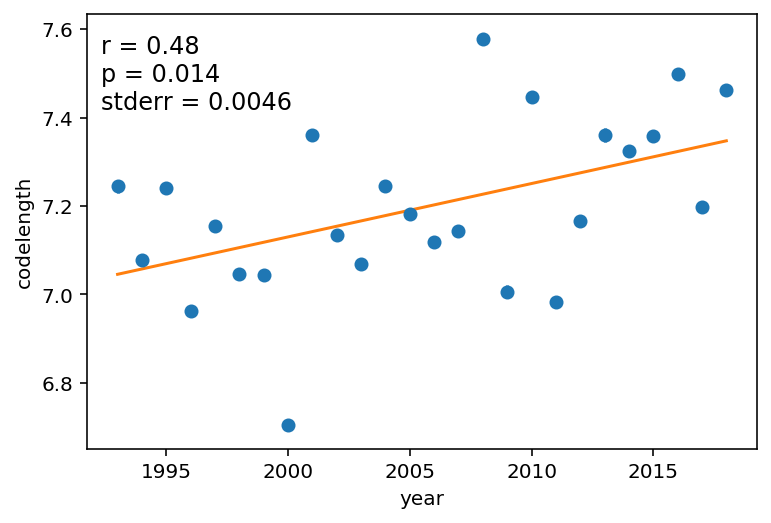

In [40]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), septDF['avg_codelength'])
plt.errorbar(np.arange(1993, 2019), septDF['avg_codelength'].values, yerr=septDF['std_codelength'], fmt='o')
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s)
plt.ylabel("codelength")
plt.xlabel("year")
# plt.margins(x=0, y=0.1)
ax=plt.gca()
ax.text(0.02, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
#plt.tight_layout(True)
plt.savefig("figures/evol_codelength_sept.pdf", dpi=300, bbox_inches='tight')

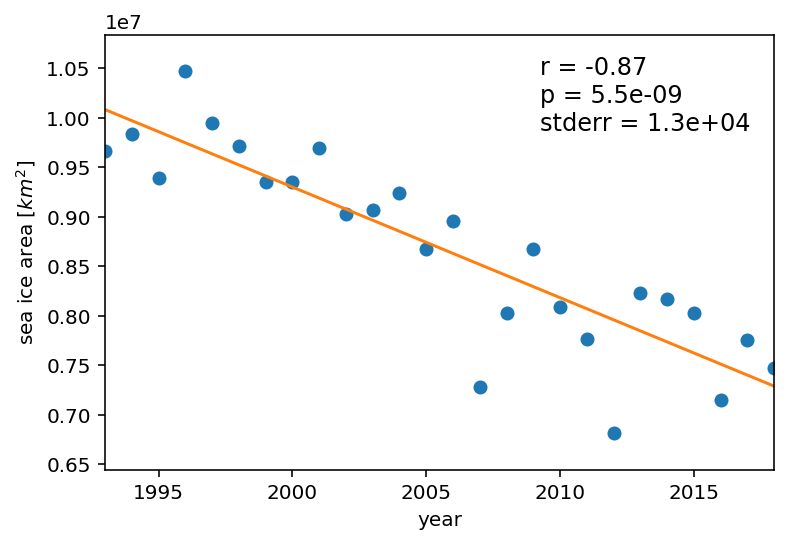

In [41]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), septDF['sea_ice'])
plt.scatter(np.arange(1993, 2019), septDF['sea_ice'])
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s, c='C1')
plt.ylabel(r"sea ice area [$km^2$]")
plt.xlabel("year")
plt.margins(x=0, y=0.1)
ax=plt.gca()
ax.text(0.65, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
plt.savefig("figures/evol_sea_ice_sept.pdf", dpi=300, bbox_inches='tight')

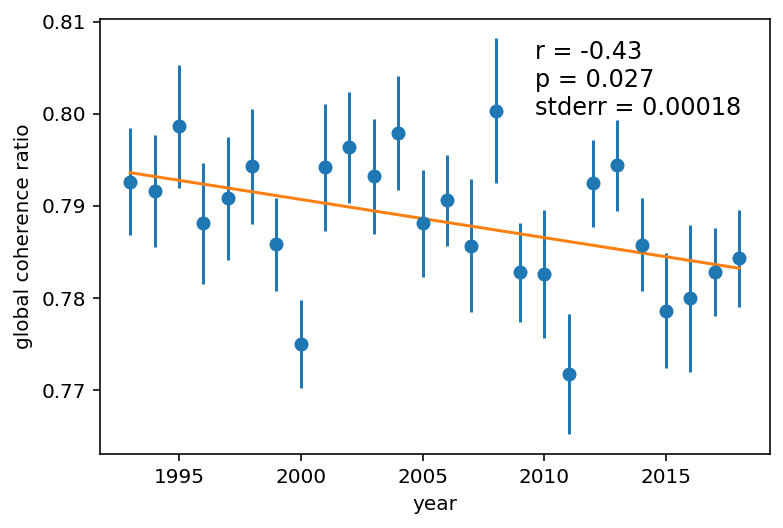

In [42]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), septDF['avg_global_coherence'])
plt.errorbar(np.arange(1993, 2019), septDF['avg_global_coherence'].values, yerr=septDF['std_global_coherence'], fmt='o')
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s)
plt.ylabel("global coherence ratio")
plt.xlabel("year")
# plt.margins(x=0, y=0.1)
ax = plt.gca()
ax.text(0.65, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
plt.savefig("figures/evol_coherence_sept.pdf", dpi=300, bbox_inches='tight')

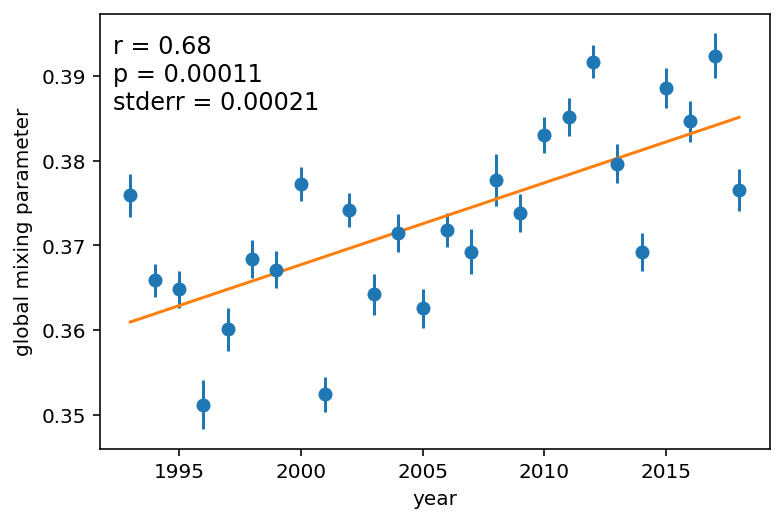

In [43]:
(a_s, b_s, r, pvalue, stderr) = linregress(np.arange(1993, 2019), septDF['avg_global_mixing'])
plt.errorbar(np.arange(1993, 2019), septDF['avg_global_mixing'].values, yerr=septDF['std_global_mixing'], fmt='o')
plt.plot(np.arange(1993, 2019), np.arange(1993, 2019)*a_s+b_s)
plt.ylabel("global mixing parameter")
plt.xlabel("year")
# plt.margins(x=0, y=0.1)
ax = plt.gca()
ax.text(0.02, 0.78, 'r = {:0.2}'.format(r)+'\np = {:0.2}'.format(pvalue)+'\nstderr = {:0.2}'.format(stderr), color='black', fontsize='12', transform=ax.transAxes, horizontalalignment='left')
plt.savefig("figures/evol_mixing_sept.pdf", dpi=300, bbox_inches='tight')

## 2017 (Monthly)

In [4]:
dict2017 = {}
for month in range(1, 13):
    dict2017[month] = {}

for month in range(1, 13):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2017-{month}-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S2017-{month}-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    dict2017[month]['avg_codelength'] = np.mean(results['codelengths'])
    dict2017[month]['std_codelength'] = np.std(results['codelengths'])
    dict2017[month]['avg_global_coherence'] = results['avg_global_coherence']
    dict2017[month]['std_global_coherence'] = np.std(results['globalCoherence'])
    dict2017[month]['avg_global_mixing'] = results['avg_global_mixing']
    dict2017[month]['std_global_mixing'] = np.std(results['globalMixing'])
DF2017 = pd.DataFrame.from_dict(dict2017, orient='index')

In [8]:
DF2017["std_codelength"].mean()

0.010334810333732822

In [52]:
seaIceArr2017 = []
for month in range(1, 13):
    if month <= 9:
        month = "0"+str(month)
    ds = xr.open_dataset(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_2017{month}.nc")
    seaIceArr2017.append(np.nansum(cell_areas*ds.siconc[0, 1680:, :])/1000000)
DF2017["sea_ice"] = seaIceArr2017

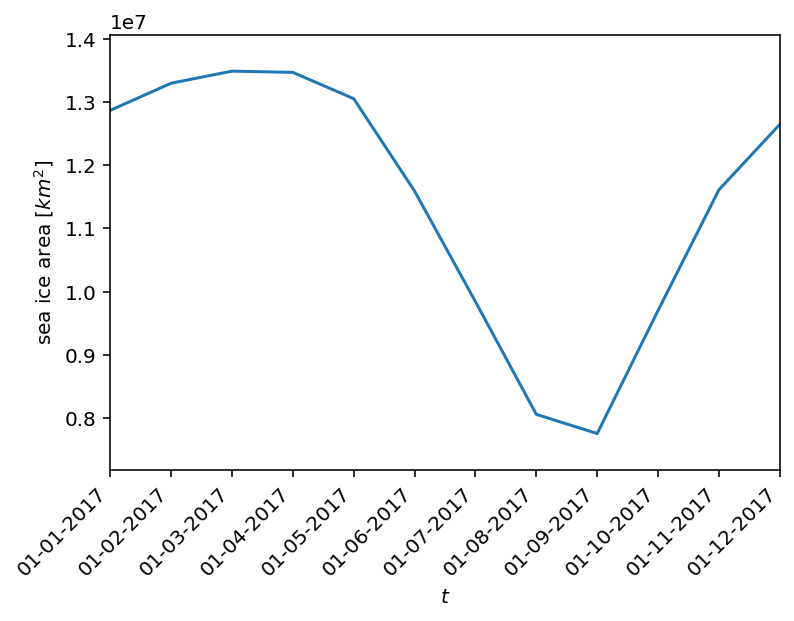

In [57]:
plt.plot(np.arange(1, 13), DF2017['sea_ice'].values)
plt.ylabel(r"sea ice area [$km^2$]")
plt.xlabel(f"$t$")
plt.margins(x=0, y=0.1)
#plt.tight_layout(True)
ax = plt.gca()
dates = pd.DatetimeIndex([f'2017-{month}-1' for month in range(1,13)]).strftime('%d-%m-%Y')
# ticklabels = [datetime.date(2017, item, 1).strftime('%b') for item in np.arange(1,13)]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(dates, rotation=45, ha='right')
plt.savefig("figures/evol_sea_ice_2017monthly.pdf", dpi=300, bbox_inches='tight')

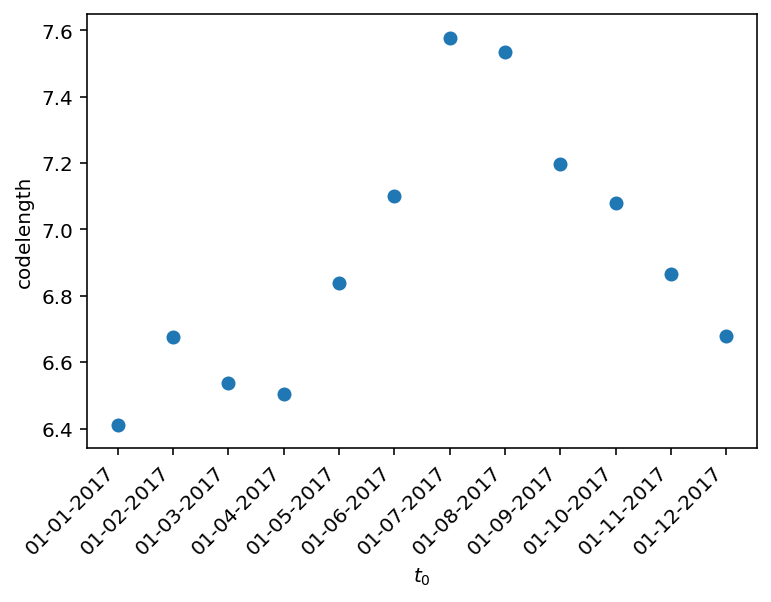

In [34]:
plt.errorbar(np.arange(1, 13), DF2017['avg_codelength'].values, yerr=DF2017['std_codelength'].values, fmt='o')
plt.ylabel("codelength")
plt.xlabel(f"$t_0$")
# plt.margins(x=0, y=0.1)
#plt.tight_layout(True)
ax = plt.gca()
dates = pd.DatetimeIndex([f'2017-{month}-1' for month in range(1,13)]).strftime('%d-%m-%Y')
# ticklabels = [datetime.date(2017, item, 1).strftime('%b') for item in np.arange(1,13)]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(dates, rotation=45, ha='right')
plt.savefig("figures/evol_codelength_2017monthly.pdf", dpi=300, bbox_inches='tight')

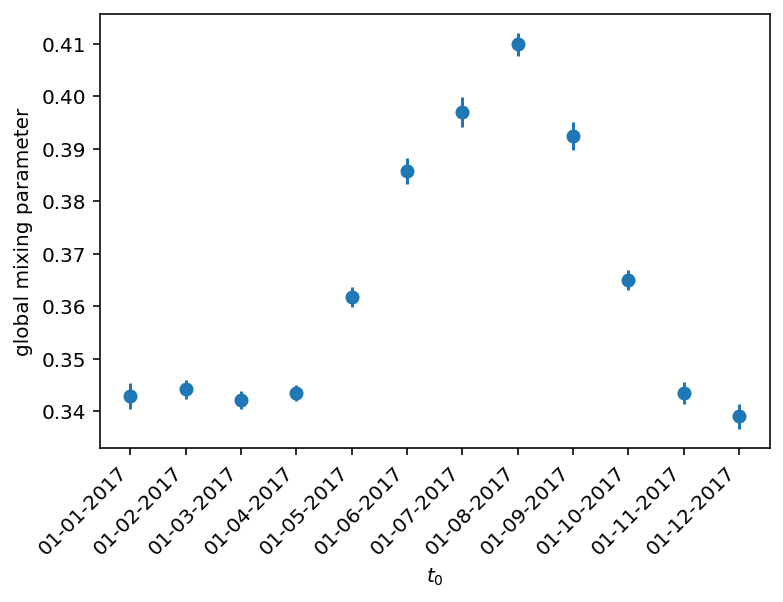

In [38]:
plt.errorbar(np.arange(1, 13), DF2017['avg_global_mixing'].values, yerr=DF2017['std_global_mixing'].values, fmt='o')
plt.ylabel("global mixing parameter")
plt.xlabel(f"$t_0$")
# plt.margins(x=0, y=0.1)
#plt.tight_layout(True)
ax = plt.gca()
dates = pd.DatetimeIndex([f'2017-{month}-1' for month in range(1,13)]).strftime('%d-%m-%Y')
# ticklabels = [datetime.date(2017, item, 1).strftime('%b') for item in np.arange(1,13)]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(dates, rotation=45, ha='right')
plt.savefig("figures/evol_mixing_2017monthly.pdf", dpi=300, bbox_inches='tight')

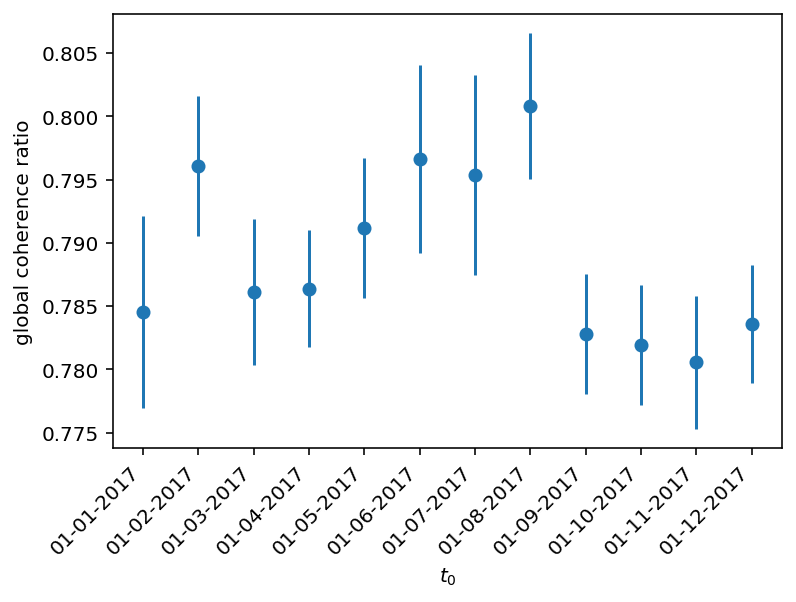

In [39]:
plt.errorbar(np.arange(1, 13), DF2017['avg_global_coherence'].values, yerr=DF2017['std_global_coherence'].values, fmt='o')
plt.ylabel("global coherence ratio")
plt.xlabel(f"$t_0$")
# plt.margins(x=0, y=0.1)
#plt.tight_layout(True)
ax = plt.gca()
dates = pd.DatetimeIndex([f'2017-{month}-1' for month in range(1,13)]).strftime('%d-%m-%Y')
# ticklabels = [datetime.date(2017, item, 1).strftime('%b') for item in np.arange(1,13)]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(dates, rotation=45, ha='right')
plt.savefig("figures/evol_coherence_2017monthly.pdf", dpi=300, bbox_inches='tight')

In [58]:
DF2017.corr()

,avg_codelength,std_codelength,avg_global_coherence,std_global_coherence,avg_global_mixing,std_global_mixing,sea_ice
avg_codelength,1.000000,0.482567,0.489307,0.226681,0.928829,0.546096,-0.854219
std_codelength,0.482567,1.000000,0.257240,0.531060,0.412472,0.651974,-0.389410
avg_global_coherence,0.489307,0.257240,1.000000,0.475696,0.571942,0.086120,-0.143506
std_global_coherence,0.226681,0.531060,0.475696,1.000000,0.308563,0.578679,0.019285
avg_global_mixing,0.928829,0.412472,0.571942,0.308563,1.000000,0.540697,-0.845132
std_global_mixing,0.546096,0.651974,0.086120,0.578679,0.540697,1.000000,-0.518994
sea_ice,-0.854219,-0.389410,-0.143506,0.019285,-0.845132,-0.518994,1.000000


In [60]:
DF2017.corr(method=lambda x, y: pearsonr(x, y)[1])

,avg_codelength,std_codelength,avg_global_coherence,std_global_coherence,avg_global_mixing,std_global_mixing,sea_ice
avg_codelength,1.000000,0.112067,0.106420,0.478648,0.000013,0.066228,0.000404
std_codelength,0.112067,1.000000,0.419579,0.075629,0.182699,0.021594,0.210854
avg_global_coherence,0.106420,0.419579,1.000000,0.118024,0.052011,0.790145,0.656361
std_global_coherence,0.478648,0.075629,0.118024,1.000000,0.329152,0.048689,0.952563
avg_global_mixing,0.000013,0.182699,0.052011,0.329152,1.000000,0.069506,0.000538
std_global_mixing,0.066228,0.021594,0.790145,0.048689,0.069506,1.000000,0.083804
sea_ice,0.000404,0.210854,0.656361,0.952563,0.000538,0.083804,1.000000
